In [2]:
# Base utilities
import os

# Data Mining
import math
import random
random_state = 42
random.seed(random_state)
seed=random_state
import numpy as np 
import pandas as pd
import geopandas as gpd
import osmnx as ox
import pandana as pdn
import pickle as pkl
import folium

# Plot
import matplotlib.pyplot as plt
import matplotlib.pyplot as plot
import seaborn as sns

# Learning
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, train_test_split, KFold

# Models
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Directories
for d in ["data", "logs", "models", "networks"]:
    if not os.path.isdir(d):
        os.mkdir(d)

## Trips

In [2]:
# Bring the trips
trips = pd.read_csv(f"data/trips_gipuzkoa.csv")

# Clean trips dataset

# Primero quedarme solo con las filas que tienen como origen y destino Gipuzkoa. Ya lo extenderé en siguientes pasos, pero incluir GTFSs de alava y vizcaya también es un coñazo.

condicion1 = trips['TTHH ORI'] == 'Gipuzkoa'
condicion2 = trips['TTHH DES'] == 'Gipuzkoa'
trips = trips[condicion1 & condicion2]

columns_to_drop=['Numero etapas','Tipo desplazamiento','MODO_BINARIO','Territorio', 'TTHH ORI', 'TTHH DES']
trips=trips.drop(columns=columns_to_drop)

In [3]:
# Expandir los trips, hacer que cada trayecto sea una fila

# Crear una lista de filas duplicadas
nuevas_filas = []
for index, row in trips.iterrows():
    valores_columnas = row[trips.columns]
    repeticiones = row['Desplazamientos']
    nuevas_filas.extend([valores_columnas] * repeticiones)

# Crear un nuevo DataFrame con las filas duplicadas
trips = pd.DataFrame(nuevas_filas, columns=trips.columns)

# Elimino la columna desplazamientos que ya no tiene sentido alguno
trips = trips.drop(columns=["Desplazamientos"])

# Mezclo las filas de manera aleatoria
trips = trips.sample(frac=1).reset_index(drop=True)
trips

KeyboardInterrupt: 

## Editar los trips para asignar edificio adecuadamente

In [4]:
# Quedarme solo con commute

trips = trips[trips['MOTIVO_informe']=='Trabajo habitual']
trips = trips.drop(columns='MOTIVO_informe')
len(trips)

509058

In [5]:
# Dividir el dataset en: commutes entre pueblos y entre un mismo pueblo.
trips_1 = trips[trips['Poblacion ORIGEN'] != trips['Poblacion DESTINO']]
trips_2 = trips[trips['Poblacion ORIGEN'] == trips['Poblacion DESTINO']]

# 1: De los commutes entre pueblos, elimino los que son de vuelta de trabajo: DESTINO=Poblacion. 
# Mantengo los que tienen ORIGEN=Poblacion y los que Poblacion=OTRO (muy pocos)

trips_1 = trips_1[~(trips_1['Poblacion ORIGEN'] != trips_1['Poblacion'])]

# 2: De los commutes de un mismo pueblo, tengo que eliminar la mitad, pero con sentido.
# Para ello agrupo los desplazamientos y divido por la mitad cada fila. Y luego expando los desplazamientos.

trips_2 = trips_2.groupby(['Poblacion ORIGEN', 'Poblacion DESTINO', 'MODO_INFORME',
        'Poblacion', 'Grupo edad', 'Actividad economica',
       'COMARCA ORI', 'COMARCA DES', 'Genero', 'Tipo de familia']).size().reset_index(name='Desplazamientos')

trips_2['Desplazamientos'] = trips_2['Desplazamientos']/2
trips_2['Desplazamientos'] = trips_2['Desplazamientos'].astype(int)

# Expandir los trips, hacer que cada trayecto sea una fila

# Crear una lista de filas duplicadas
nuevas_filas = []
for index, row in trips_2.iterrows():
    valores_columnas = row[trips.columns]
    repeticiones = row['Desplazamientos']
    nuevas_filas.extend([valores_columnas] * repeticiones)

# Crear un nuevo DataFrame con las filas duplicadas
trips_2 = pd.DataFrame(nuevas_filas, columns=trips_2.columns)

# Elimino la columna desplazamientos que ya no tiene sentido alguno
trips_2 = trips_2.drop(columns=["Desplazamientos"])

# Mezclo las filas de manera aleatoria
trips_2 = trips_2.sample(frac=1).reset_index(drop=True)
trips_2

,Poblacion ORIGEN,Poblacion DESTINO,MODO_INFORME,Poblacion,Grupo edad,Actividad economica,COMARCA ORI,COMARCA DES,Genero,Tipo de familia
0,Donostia/San Sebastian,Donostia/San Sebastian,Autobus urbano,Donostia/San Sebastian,20-44,Personas ocupadas,Donostialdea,Donostialdea,Hombre,Matrimonio o pareja sin hijos/as
1,Irun,Irun,"Coche, conductor/a",Irun,45-64,Personas ocupadas,Bidasoa,Bidasoa,Mujer,Monoparental
2,Zumaia,Zumaia,Andando,Zumaia,20-44,Personas ocupadas,Urola Kosta,Urola Kosta,Mujer,Otras tipologias
3,Donostia/San Sebastian,Donostia/San Sebastian,Autobus urbano,Donostia/San Sebastian,20-44,Personas ocupadas,Donostialdea,Donostialdea,Mujer,Unipersonal
4,Donostia/San Sebastian,Donostia/San Sebastian,Tren Metro SS/Topo,Donostia/San Sebastian,45-64,Personas ocupadas,Donostialdea,Donostialdea,Hombre,Unipersonal
...,...,...,...,...,...,...,...,...,...,...
119610,Donostia/San Sebastian,Donostia/San Sebastian,"Coche, conductor/a",Donostia/San Sebastian,20-44,Personas ocupadas,Donostialdea,Donostialdea,Mujer,Matrimonio o pareja con hijos/as
119611,Errenteria,Errenteria,"Coche, conductor/a",Errenteria,45-64,Personas ocupadas,Donostialdea,Donostialdea,Hombre,Matrimonio o pareja con hijos/as
119612,Aretxabaleta,Aretxabaleta,Bicicleta,Aretxabaleta,20-44,Personas ocupadas,Debagoiena,Debagoiena,Hombre,Monoparental
119613,Arrasate/Mondragon,Arrasate/Mondragon,"Coche, conductor/a",Arrasate/Mondragon,45-64,Personas ocupadas,Debagoiena,Debagoiena,Hombre,Matrimonio o pareja con hijos/as


In [6]:
# Ahora agrupo estos dos datasets en uno

trips = pd.concat([trips_1, trips_2], ignore_index=True)
len(trips)

# Esta bien porque es mas o menos la mitad de los originales

254660

In [7]:
# Leer el archivo Shapefile
gdf = gpd.read_file(f"data/ERAIKINAK_EDIFICIOS/buildings.shp")
gdf

,Town,Edificabil,Solar,Vivienda,Trastero,Garaje Cer,Agropecuar,Local Come,Industrial,Almacen,...,Terraza,Accesos y,Jardin,Sanidad,Deposito,Duplex,Plaza Park,Religioso,Espectacul,geometry
0,Andoain,0,0,267,92,0,188,0,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((579409.327 4784688.273, 579409.547 4..."
1,Andoain,0,0,160,0,30,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((579379.507 4784661.604, 579387.677 4..."
2,Andoain,0,0,108,153,108,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((579380.339 4784743.544, 579384.819 4..."
3,Andoain,0,0,348,116,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((579330.770 4784723.036, 579326.320 4..."
4,Andoain,0,0,360,108,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((579342.980 4784760.725, 579358.430 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45095,Astigarraga,0,0,278,30,29,200,0,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((586462.762 4793342.393, 586459.195 4..."
45096,Astigarraga,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((584866.974 4791359.814, 584862.416 4..."
45097,Astigarraga,0,0,177,58,138,0,0,0,0,...,24,0,0,0,0,0,0,0,0,"POLYGON ((587961.921 4793110.765, 587965.084 4..."
45098,Astigarraga,0,0,329,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((587961.921 4793110.765, 587967.874 4..."


In [8]:
# Pasar las geometrias de los edificios de sistema UTM a sistema decimal de coordenadas
crs_objetivo = 'EPSG:4326'  # WGS84
gdf = gdf.to_crs(crs_objetivo)

# Crear una columna que contiene el centroide del edificio, para obtener un punto
gdf['Centroide'] = gdf['geometry'].centroid
gdf

C:\Users\iazka\AppData\Local\Temp\ipykernel_39408\2453189448.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['Centroide'] = gdf['geometry'].centroid


,Town,Edificabil,Solar,Vivienda,Trastero,Garaje Cer,Agropecuar,Local Come,Industrial,Almacen,...,Accesos y,Jardin,Sanidad,Deposito,Duplex,Plaza Park,Religioso,Espectacul,geometry,Centroide
0,Andoain,0,0,267,92,0,188,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-2.02241 43.21080, -2.02240 43.21091...",POINT (-2.02231 43.21083)
1,Andoain,0,0,160,0,30,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-2.02278 43.21056, -2.02267 43.21071...",POINT (-2.02264 43.21061)
2,Andoain,0,0,108,153,108,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-2.02276 43.21130, -2.02270 43.21142...",POINT (-2.02266 43.21134)
3,Andoain,0,0,348,116,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-2.02337 43.21112, -2.02342 43.21120...",POINT (-2.02330 43.21120)
4,Andoain,0,0,360,108,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-2.02321 43.21146, -2.02302 43.21154...",POINT (-2.02309 43.21146)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45095,Astigarraga,0,0,278,30,29,200,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-1.93423 43.28794, -1.93427 43.28788...",POINT (-1.93401 43.28792)
45096,Astigarraga,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-1.95420 43.27027, -1.95426 43.27043...",POINT (-1.95417 43.27036)
45097,Astigarraga,0,0,177,58,138,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-1.91579 43.28568, -1.91575 43.28569...",POINT (-1.91568 43.28558)
45098,Astigarraga,0,0,329,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"POLYGON ((-1.91579 43.28568, -1.91572 43.28549...",POINT (-1.91582 43.28554)


<Axes: >

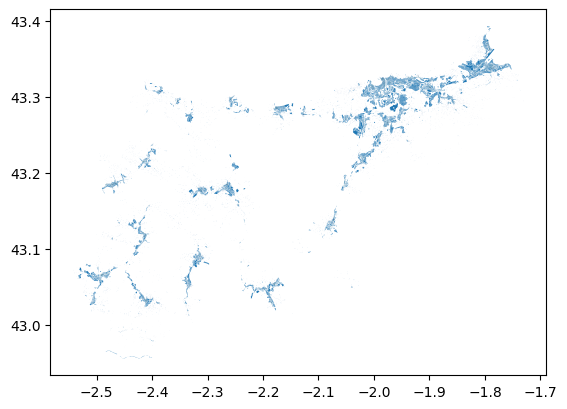

In [9]:
gdf.plot()

## Merge trips and shp

In [9]:
# Ahora tengo que hacer que los nombres de los pueblos sean iguales en "gdf" y en "trips"
# Voy a coger como referencia el nombre en "trips" y cambiar los del shapefile

diferentes_lista1 = list(set(trips['Poblacion DESTINO'].unique()) - set(gdf['Town'].unique()))
diferentes_lista1

['Tolosaldea',
 'Urola Kosta',
 'Debagoiena / Alto Deba',
 'Goierri',
 'Debabarrena / Bajo Deba']

In [10]:
# En un siguiente paso, los trips que tienen como Poblacion ORIGEN o DESTINO una comarca, las tendré que asignar a un pueblo.
# Por ahora, elimino esos trips
# Pasa de 1806547 trips a 1656191

trips = trips.loc[trips['Poblacion ORIGEN'] != 'Debabarrena / Bajo Deba']
trips = trips.loc[trips['Poblacion DESTINO'] != 'Debabarrena / Bajo Deba']
trips = trips.loc[trips['Poblacion ORIGEN'] != 'Goierri']
trips = trips.loc[trips['Poblacion DESTINO'] != 'Goierri']
trips = trips.loc[trips['Poblacion ORIGEN'] != 'Debagoiena / Alto Deba']
trips = trips.loc[trips['Poblacion DESTINO'] != 'Debagoiena / Alto Deba']
trips = trips.loc[trips['Poblacion ORIGEN'] != 'Tolosaldea']
trips = trips.loc[trips['Poblacion DESTINO'] != 'Tolosaldea']
trips = trips.loc[trips['Poblacion ORIGEN'] != 'Urola Kosta']
trips = trips.loc[trips['Poblacion DESTINO'] != 'Urola Kosta']
len(trips)

223519

In [11]:
# Ahora, todos los pueblos que están en trips, están en MUNI_E

diferentes_lista1 = list(set(trips['Poblacion DESTINO'].unique()) - set(gdf['Town'].unique()))
diferentes_lista1

[]

In [12]:
# Asignar un edificio a cada origen y a cada destino
# 54 mins

# Función para asignar coord_origen basado en la probabilidad de vivienda
def asignar_coord_origen(row):
    matching_rows = gdf[gdf['Town'] == row['Poblacion ORIGEN']]
    
    if not matching_rows.empty:
        vivienda_total = matching_rows['Vivienda'].sum()
        probabilities = matching_rows['Vivienda'] / vivienda_total
        chosen_row = random.choices(matching_rows.index, weights=probabilities)[0]
        return gdf.loc[chosen_row, 'Centroide']
    else:
        return None

# Función para asignar coord_origen basado en la probabilidad de vivienda
def asignar_coord_destino(row):
    matching_rows = gdf[gdf['Town'] == row['Poblacion DESTINO']]
    
    if not matching_rows.empty:
        vivienda_total = matching_rows['Oficina'].sum()
        probabilities = matching_rows['Oficina'] / vivienda_total
        chosen_row = random.choices(matching_rows.index, weights=probabilities)[0]
        return gdf.loc[chosen_row, 'Centroide']
    else:
        return None

# Aplicar la función a trips para crear la columna Edif_ORIGEN y Edif_DESTINO
trips['Edif_ORIGEN'] = trips.apply(asignar_coord_origen, axis=1)
trips['Edif_DESTINO'] = trips.apply(asignar_coord_destino, axis=1)
trips

,Poblacion ORIGEN,Poblacion DESTINO,MODO_INFORME,Poblacion,Grupo edad,Actividad economica,COMARCA ORI,COMARCA DES,Genero,Tipo de familia,Edif_ORIGEN,Edif_DESTINO
0,Lasarte-Oria,Donostia/San Sebastian,"Coche, conductor/a",Lasarte-Oria,45-64,Personas ocupadas,Donostialdea,Donostialdea,Mujer,Matrimonio o pareja sin hijos/as,POINT (-2.016189171038348 43.261062244013104),POINT (-1.9843288232112375 43.31960705120699)
1,Irun,Donostia/San Sebastian,"Coche, conductor/a",Irun,45-64,Personas ocupadas,Bidasoa,Donostialdea,Hombre,Matrimonio o pareja con hijos/as,POINT (-1.8015954088188253 43.33608756051584),POINT (-1.970825544787505 43.310747681066246)
3,Irun,Hondarribia,"Coche, conductor/a",Irun,45-64,Personas ocupadas,Bidasoa,Bidasoa,Mujer,Matrimonio o pareja con hijos/as,POINT (-1.7846566708050309 43.34095934331219),POINT (-1.8240218591673365 43.34970207085332)
4,Pasaia,Donostia/San Sebastian,"Coche, pasajero/a",Pasaia,20-44,Personas ocupadas,Donostialdea,Donostialdea,Mujer,Unipersonal,POINT (-1.9192320061592212 43.32540792029387),POINT (-1.9840107970919545 43.29180829032919)
5,Andoain,Zarautz,"Coche, conductor/a",Andoain,45-64,Personas ocupadas,Donostialdea,Urola Kosta,Hombre,Unipersonal,POINT (-2.0214033973630605 43.220607558510125),POINT (-2.1749429339403954 43.27788171517416)
...,...,...,...,...,...,...,...,...,...,...,...,...
254655,Donostia/San Sebastian,Donostia/San Sebastian,"Coche, conductor/a",Donostia/San Sebastian,20-44,Personas ocupadas,Donostialdea,Donostialdea,Mujer,Matrimonio o pareja con hijos/as,POINT (-1.9875502460407626 43.30062525609409),POINT (-1.9801647376001739 43.30861767979669)
254656,Errenteria,Errenteria,"Coche, conductor/a",Errenteria,45-64,Personas ocupadas,Donostialdea,Donostialdea,Hombre,Matrimonio o pareja con hijos/as,POINT (-1.9082377644744748 43.31014791836973),POINT (-1.89444892187452 43.299134590606144)
254657,Aretxabaleta,Aretxabaleta,Bicicleta,Aretxabaleta,20-44,Personas ocupadas,Debagoiena,Debagoiena,Hombre,Monoparental,POINT (-2.504105861061953 43.032411022443355),POINT (-2.5030871676275694 43.02726909827494)
254658,Arrasate/Mondragon,Arrasate/Mondragon,"Coche, conductor/a",Arrasate/Mondragon,45-64,Personas ocupadas,Debagoiena,Debagoiena,Hombre,Matrimonio o pareja con hijos/as,POINT (-2.4844325300587835 43.06880487146077),POINT (-2.494675911892882 43.057950699413155)


In [17]:
trips = trips.reset_index()
trips = trips.drop(columns='index')
trips

,index,Poblacion ORIGEN,Poblacion DESTINO,MODO_INFORME,Poblacion,Grupo edad,Actividad economica,COMARCA ORI,COMARCA DES,Genero,Tipo de familia,Edif_ORIGEN,Edif_DESTINO
0,0,Lasarte-Oria,Donostia/San Sebastian,"Coche, conductor/a",Lasarte-Oria,45-64,Personas ocupadas,Donostialdea,Donostialdea,Mujer,Matrimonio o pareja sin hijos/as,POINT (-2.016189171038348 43.261062244013104),POINT (-1.9843288232112375 43.31960705120699)
1,1,Irun,Donostia/San Sebastian,"Coche, conductor/a",Irun,45-64,Personas ocupadas,Bidasoa,Donostialdea,Hombre,Matrimonio o pareja con hijos/as,POINT (-1.8015954088188253 43.33608756051584),POINT (-1.970825544787505 43.310747681066246)
2,3,Irun,Hondarribia,"Coche, conductor/a",Irun,45-64,Personas ocupadas,Bidasoa,Bidasoa,Mujer,Matrimonio o pareja con hijos/as,POINT (-1.7846566708050309 43.34095934331219),POINT (-1.8240218591673365 43.34970207085332)
3,4,Pasaia,Donostia/San Sebastian,"Coche, pasajero/a",Pasaia,20-44,Personas ocupadas,Donostialdea,Donostialdea,Mujer,Unipersonal,POINT (-1.9192320061592212 43.32540792029387),POINT (-1.9840107970919545 43.29180829032919)
4,5,Andoain,Zarautz,"Coche, conductor/a",Andoain,45-64,Personas ocupadas,Donostialdea,Urola Kosta,Hombre,Unipersonal,POINT (-2.0214033973630605 43.220607558510125),POINT (-2.1749429339403954 43.27788171517416)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
223514,254655,Donostia/San Sebastian,Donostia/San Sebastian,"Coche, conductor/a",Donostia/San Sebastian,20-44,Personas ocupadas,Donostialdea,Donostialdea,Mujer,Matrimonio o pareja con hijos/as,POINT (-1.9875502460407626 43.30062525609409),POINT (-1.9801647376001739 43.30861767979669)
223515,254656,Errenteria,Errenteria,"Coche, conductor/a",Errenteria,45-64,Personas ocupadas,Donostialdea,Donostialdea,Hombre,Matrimonio o pareja con hijos/as,POINT (-1.9082377644744748 43.31014791836973),POINT (-1.89444892187452 43.299134590606144)
223516,254657,Aretxabaleta,Aretxabaleta,Bicicleta,Aretxabaleta,20-44,Personas ocupadas,Debagoiena,Debagoiena,Hombre,Monoparental,POINT (-2.504105861061953 43.032411022443355),POINT (-2.5030871676275694 43.02726909827494)
223517,254658,Arrasate/Mondragon,Arrasate/Mondragon,"Coche, conductor/a",Arrasate/Mondragon,45-64,Personas ocupadas,Debagoiena,Debagoiena,Hombre,Matrimonio o pareja con hijos/as,POINT (-2.4844325300587835 43.06880487146077),POINT (-2.494675911892882 43.057950699413155)


In [19]:
trips.to_csv(f"data/Gipuzkoa_1.csv")

In [62]:
trips = pd.read_csv(f"data/Gipuzkoa_1.csv",index_col=0)

In [63]:
trips = trips[trips['Poblacion DESTINO'] != trips['Poblacion ORIGEN']]
trips=trips.reset_index()
trips=trips.drop(columns='index')

## Para el estudio simple, sin asignar edificio

In [ ]:
trips = trips.drop(columns=['Edif_ORIGEN', 'Edif_DESTINO'])

In [26]:
pueblos = pd.read_excel(f"data/pueblos_gipuzkoa.xlsx",index_col=0)
pueblos.columns

Index(['Region', 'Latitud', 'Longitud', 'Comarca', 'Altitud (m.s.n.m.)',
       'Superficie (kmÂ²)', 'PoblaciÃ³n (2019)', 'Densidad (hab./kmÂ²)',
       'Código'],
      dtype='object')

In [27]:
trips = pd.merge(trips, pueblos, left_on='Poblacion ORIGEN', right_on='Town', how='left')
trips = trips.drop(columns=['Region','Comarca', 'Altitud (m.s.n.m.)',
       'Superficie (kmÂ²)', 'PoblaciÃ³n (2019)', 'Densidad (hab./kmÂ²)',
       'Código'])
trips = trips.rename(columns={'Latitud': 'O_lat', 'Longitud': 'O_long'})

trips = pd.merge(trips, pueblos, left_on='Poblacion DESTINO', right_on='Town', how='left')
trips = trips.drop(columns=['Region','Comarca', 'Altitud (m.s.n.m.)',
       'Superficie (kmÂ²)', 'PoblaciÃ³n (2019)', 'Densidad (hab./kmÂ²)',
       'Código'])
trips = trips.rename(columns={'Latitud': 'D_lat', 'Longitud': 'D_long'})

trips

,Poblacion ORIGEN,Poblacion DESTINO,MODO_INFORME,Poblacion,Grupo edad,Actividad economica,COMARCA ORI,COMARCA DES,Genero,Tipo de familia,O_lat,O_long,D_lat,D_long
0,Lasarte-Oria,Donostia/San Sebastian,"Coche, conductor/a",Lasarte-Oria,45-64,Personas ocupadas,Donostialdea,Donostialdea,Mujer,Matrimonio o pareja sin hijos/as,43.263787,-2.011931,43.291811,-1.988513
1,Irun,Donostia/San Sebastian,"Coche, conductor/a",Irun,45-64,Personas ocupadas,Bidasoa,Donostialdea,Hombre,Matrimonio o pareja con hijos/as,43.318641,-1.773726,43.291811,-1.988513
2,Irun,Hondarribia,"Coche, conductor/a",Irun,45-64,Personas ocupadas,Bidasoa,Bidasoa,Mujer,Matrimonio o pareja con hijos/as,43.318641,-1.773726,43.374885,-1.823971
3,Pasaia,Donostia/San Sebastian,"Coche, pasajero/a",Pasaia,20-44,Personas ocupadas,Donostialdea,Donostialdea,Mujer,Unipersonal,43.318996,-1.969857,43.291811,-1.988513
4,Andoain,Zarautz,"Coche, conductor/a",Andoain,45-64,Personas ocupadas,Donostialdea,Urola Kosta,Hombre,Unipersonal,43.219414,-2.020908,43.280963,-2.167224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107556,Arrasate/Mondragon,Oiartzun,"Coche, conductor/a",Arrasate/Mondragon,20-44,Personas ocupadas,Debagoiena,Donostialdea,Hombre,Unipersonal,43.074523,-2.484149,43.254173,-1.847457
107557,Astigarraga,Hernani,"Coche, conductor/a",Astigarraga,20-44,Personas ocupadas,Donostialdea,Donostialdea,Hombre,Unipersonal,43.279757,-1.933434,43.238783,-1.944259
107558,Irun,Bergara,"Coche, conductor/a",Irun,45-64,Personas ocupadas,Bidasoa,Debagoiena,Hombre,Matrimonio o pareja sin hijos/as,43.318641,-1.773726,43.122005,-2.414838
107559,Errenteria,Urnieta,Tren Renfe cercanias,Errenteria,20-44,Personas ocupadas,Donostialdea,Donostialdea,Mujer,Matrimonio o pareja con hijos/as,43.255305,-1.892862,43.227927,-1.964178


## Continue

In [64]:
# Pasa de un punto en formato WKT a dos columnas con LONG y LAT

from shapely import wkt
from shapely.geometry import Point

def extraer_longitud(punto_wkt):
    punto = wkt.loads(punto_wkt)
    return punto.x

def extraer_latitud(punto_wkt):
    punto = wkt.loads(punto_wkt)
    return punto.y

trips['O_long'] = trips['Edif_ORIGEN'].apply(extraer_longitud)
trips['O_lat'] = trips['Edif_ORIGEN'].apply(extraer_latitud)
trips['D_long'] = trips['Edif_DESTINO'].apply(extraer_longitud)
trips['D_lat'] = trips['Edif_DESTINO'].apply(extraer_latitud)

# Eliminar columnas innecesarias

trips = trips.drop(columns=["Edif_ORIGEN","Edif_DESTINO"])
trips

,Poblacion ORIGEN,Poblacion DESTINO,MODO_INFORME,Poblacion,Grupo edad,Actividad economica,COMARCA ORI,COMARCA DES,Genero,Tipo de familia,O_long,O_lat,D_long,D_lat
0,Lasarte-Oria,Donostia/San Sebastian,"Coche, conductor/a",Lasarte-Oria,45-64,Personas ocupadas,Donostialdea,Donostialdea,Mujer,Matrimonio o pareja sin hijos/as,-2.016189,43.261062,-1.984329,43.319607
1,Irun,Donostia/San Sebastian,"Coche, conductor/a",Irun,45-64,Personas ocupadas,Bidasoa,Donostialdea,Hombre,Matrimonio o pareja con hijos/as,-1.801595,43.336088,-1.970826,43.310748
2,Irun,Hondarribia,"Coche, conductor/a",Irun,45-64,Personas ocupadas,Bidasoa,Bidasoa,Mujer,Matrimonio o pareja con hijos/as,-1.784657,43.340959,-1.824022,43.349702
3,Pasaia,Donostia/San Sebastian,"Coche, pasajero/a",Pasaia,20-44,Personas ocupadas,Donostialdea,Donostialdea,Mujer,Unipersonal,-1.919232,43.325408,-1.984011,43.291808
4,Andoain,Zarautz,"Coche, conductor/a",Andoain,45-64,Personas ocupadas,Donostialdea,Urola Kosta,Hombre,Unipersonal,-2.021403,43.220608,-2.174943,43.277882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107556,Arrasate/Mondragon,Oiartzun,"Coche, conductor/a",Arrasate/Mondragon,20-44,Personas ocupadas,Debagoiena,Donostialdea,Hombre,Unipersonal,-2.479729,43.066429,-1.867396,43.316642
107557,Astigarraga,Hernani,"Coche, conductor/a",Astigarraga,20-44,Personas ocupadas,Donostialdea,Donostialdea,Hombre,Unipersonal,-1.936854,43.285041,-1.998340,43.275611
107558,Irun,Bergara,"Coche, conductor/a",Irun,45-64,Personas ocupadas,Bidasoa,Debagoiena,Hombre,Matrimonio o pareja sin hijos/as,-1.789741,43.334323,-2.413049,43.117452
107559,Errenteria,Urnieta,Tren Renfe cercanias,Errenteria,20-44,Personas ocupadas,Donostialdea,Donostialdea,Mujer,Matrimonio o pareja con hijos/as,-1.900697,43.311284,-1.992288,43.239125


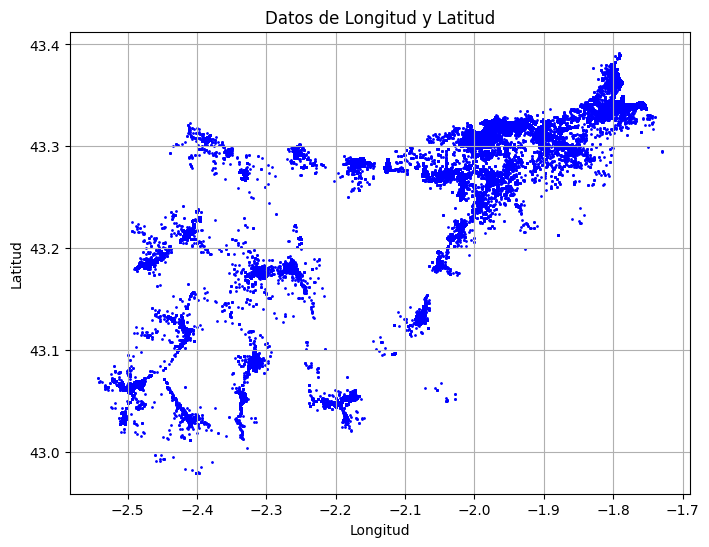

In [26]:
# Voy a plotear los puntos para ver que estan en los centros de la ciudad

origen_destino = pd.DataFrame({
    'Longitud': trips['O_long'].tolist() + trips['D_long'].tolist(),
    'Latitud': trips['O_lat'].tolist() + trips['D_lat'].tolist()
})
origen_destino

# Crear el grafico

# If we compare this graph to the one in QGIS with just the  uildings from these 34 towns, we can see it is a pretty good stimate

plt.figure(figsize=(8, 6))
plt.scatter(origen_destino['Longitud'], origen_destino['Latitud'], color='blue', marker='o', s=1)
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Datos de Longitud y Latitud')
plt.grid(True)
plt.show()

## Add characteristics and modify the trip data for MoCho

In [65]:
# Bucle que recorre todos los primary_modes. Imprime label (primary_mode), y con shape[0] imprime el numero de filas que tienen ese primary_mode

for p in [f"{label}: {trips[trips.MODO_INFORME==label].shape[0]:,}" for label in trips.MODO_INFORME.unique()]:
    print(p)
print(f"Total: {trips.shape[0]:,}")

Coche, conductor/a: 76,415
Coche, pasajero/a: 6,856
Bicicleta: 1,176
Multimodal: 2,619
Autobus interurbano: 7,637
Tren EuskoTren: 1,020
Tren Renfe cercanias: 3,294
Tren Metro SS/Topo: 2,768
Andando: 1,812
Moto: 3,368
Autobus discrecional: 389
Taxi: 207
Total: 107,561


In [66]:
# Changes primary modes to a different model: auto or green_modes

trips.loc[trips.MODO_INFORME=="Coche, pasajero/a","MODO_INFORME"] = "Coche"
trips.loc[trips.MODO_INFORME=="Coche, conductor/a","MODO_INFORME"] = "Coche"
trips.loc[trips.MODO_INFORME=="Moto","MODO_INFORME"] = "Coche"
trips.loc[trips.MODO_INFORME=="Taxi","MODO_INFORME"] = "Coche"
trips.loc[trips.MODO_INFORME=="Autobus interurbano","MODO_INFORME"] = "Autobus"
trips.loc[trips.MODO_INFORME=="Autobus urbano","MODO_INFORME"] = "Autobus"
trips.loc[trips.MODO_INFORME=="Autobus discrecional","MODO_INFORME"] = "Autobus"
trips.loc[trips.MODO_INFORME=="Tren Metro SS/Topo","MODO_INFORME"] = "Tren"
trips.loc[trips.MODO_INFORME=="Tren EuskoTren","MODO_INFORME"] = "Tren"
trips.loc[trips.MODO_INFORME=="Tren Renfe cercanias","MODO_INFORME"] = "Tren"

# Voy a eliminar los multimodales

trips = trips[trips['MODO_INFORME'] != "Multimodal"]

# Vuelvo a mostrar los modos de transporte

for p in [f"{label}: {trips[trips.MODO_INFORME==label].shape[0]:,}" for label in trips.MODO_INFORME.unique()]:
    print(p)
print(f"Total: {trips.shape[0]:,}")

Coche: 86,846
Bicicleta: 1,176
Autobus: 8,026
Tren: 7,082
Andando: 1,812
Total: 104,942


In [67]:
# Reducir el numero de trips en coche a la suma del resto de modos.

# Numero de green trips
condicion = trips['MODO_INFORME'] != 'Coche'
green_trips = condicion.sum()

condicion = trips['MODO_INFORME'] == 'Coche'
coche_trips = condicion.sum()
eliminar=coche_trips-green_trips

#eliminar=len(trips['MODO_INFORME']=='Coche')-green_trips

# Escoger aleatoriamente ese numero de trips de todos los del coche

# Filtrar las filas que cumplen con el modo de transporte "coche"
coche_rows = trips[trips['MODO_INFORME'] == 'Coche']

# Seleccionar aleatoriamente X filas del conjunto de filas "coche_rows"
muestras_aleatorias = coche_rows.sample(n=eliminar)

# Eliminar las filas que no fueron seleccionadas aleatoriamente
trips = trips[~trips.index.isin(muestras_aleatorias.index)]

# Vuelvo a mostrar los modos de transporte

for p in [f"{label}: {trips[trips.MODO_INFORME==label].shape[0]:,}" for label in trips.MODO_INFORME.unique()]:
    print(p)
print(f"Total: {trips.shape[0]:,}")

Bicicleta: 1,176
Coche: 18,096
Autobus: 8,026
Tren: 7,082
Andando: 1,812
Total: 36,192


In [68]:
trips=trips.reset_index()
trips=trips.drop(columns='index')

## Asignar nuevas columnas, tiempo y coste

In [69]:
# Crea un diccionario, donde los valores son None y las claves son esas cuatro

networks = dict.fromkeys({
 "walk",
 "transit",
 "train",
 "drive",
})

# Asigna al valor correspondiente en el diccionario networks un objeto de red creado mediante el método from_hdf5() de la clase Network del módulo pdn.network. 
# Los creados con los codigos anteriores

for k in networks:
    print(k)
    networks[k] = pdn.network.Network.from_hdf5(f'networks/{k}_net.h5')

drive
transit
train
walk


## Get the route for each mode of transportation

In [52]:
# Importar los nodos de todos los networks

# train_nodes = pd.read_csv(f"data/train_nodes.csv")
# train_nodes = train_nodes.drop(columns=['net_type','id'])
# transit_nodes = pd.read_csv(f"data/transit_nodes.csv")
drive_nodes = pd.read_csv(f"data/drive_nodes.csv")
# walk_nodes = pd.read_csv(f"data/walk_nodes.csv")
drive_nodes

,id,lon,lat,id.1
0,343943,-2.463570,43.183845,343943
1,343949,-2.470075,43.180540,343949
2,423022,-2.528159,43.176193,423022
3,448001,-2.489983,43.179563,448001
4,448006,-2.481422,43.182655,448006
...,...,...,...,...
28419,11117408731,-2.042932,43.060381,11117408731
28420,11141987355,-1.867066,43.283471,11141987355
28421,11141987393,-1.863643,43.285425,11141987393
28422,11142348360,-2.008404,43.309068,11142348360


In [59]:
# Get node ids

trips["drive_O_id"] = networks['drive'].get_node_ids(trips.O_long,trips.O_lat)
trips["drive_D_id"] = networks['drive'].get_node_ids(trips.D_long,trips.D_lat)
# trips["walk_O_id"] = networks['walk'].get_node_ids(trips.O_long,trips.O_lat)
# trips["walk_O_id"] = networks['walk'].get_node_ids(trips.D_long,trips.D_lat)

# Ahora, conseguir los lat y long del nodo obtenido con el get node ids. Se puede ver que los lat y longs de origenes y destinos obtenidos con get node ids son MUY similares a los reales (MUY BUENO).
# Se observa que los lat long de origenes y destinos obtenidos con get node ids con diferentes networks son iguales, que también es muy bueno.

trips = pd.merge(trips, drive_nodes, left_on='drive_O_id', right_on='id', how='left')
trips = trips.drop(columns='id.1')
trips = trips.rename(columns={'lon': 'O_long_drive','lat': 'O_lat_drive'})
trips = pd.merge(trips, drive_nodes, left_on='drive_D_id', right_on='id', how='left')
trips = trips.drop(columns='id.1')
trips = trips.rename(columns={'lon': 'D_long_drive','lat': 'D_lat_drive'})
trips = trips.drop(columns=['id_x','id_y'])

# trips = pd.merge(trips, walk_nodes, left_on='walk_O_id', right_on='id', how='left')
# trips = trips.drop(columns=['id.1','id'])
# trips = trips.rename(columns={'lon': 'O_long_walk','lat': 'O_lat_walk'})
# trips = pd.merge(trips, walk_nodes, left_on='walk_D_id', right_on='id', how='left')
# trips = trips.drop(columns=['id.1','id'])
# trips = trips.rename(columns={'lon': 'D_long_walk','lat': 'D_lat_walk'})
# trips = trips.drop(columns='walk_O_id','walk_D_id')

trips

,Poblacion ORIGEN,Poblacion DESTINO,MODO_INFORME,Poblacion,Grupo edad,Actividad economica,COMARCA ORI,COMARCA DES,Genero,Tipo de familia,O_long,O_lat,D_long,D_lat,drive_O_id,drive_D_id,O_long_drive,O_lat_drive,D_long_drive,D_lat_drive
0,Irun,Donostia/San Sebastian,Coche,Irun,45-64,Personas ocupadas,Bidasoa,Donostialdea,Hombre,Matrimonio o pareja con hijos/as,-1.801595,43.336088,-1.970826,43.310748,539388907,1845928491,-1.800878,43.335916,-1.970655,43.311333
1,Pasaia,Donostia/San Sebastian,Coche,Pasaia,20-44,Personas ocupadas,Donostialdea,Donostialdea,Mujer,Unipersonal,-1.919232,43.325408,-1.984011,43.291808,373476974,295471537,-1.918793,43.325301,-1.984348,43.291495
2,Irun,Hondarribia,Bicicleta,Irun,20-44,Personas ocupadas,Bidasoa,Bidasoa,Hombre,Matrimonio o pareja con hijos/as,-1.818188,43.328378,-1.795185,43.374113,1474255449,481468844,-1.818823,43.328040,-1.795753,43.373075
3,Astigarraga,Donostia/San Sebastian,Autobus,Astigarraga,45-64,Personas ocupadas,Donostialdea,Donostialdea,Mujer,Matrimonio o pareja sin hijos/as,-1.949485,43.281057,-1.942401,43.316384,467701392,1864404356,-1.949526,43.280433,-1.942493,43.316608
4,Zarautz,Donostia/San Sebastian,Tren,Zarautz,20-44,Personas ocupadas,Urola Kosta,Donostialdea,Mujer,Matrimonio o pareja con hijos/as,-2.168093,43.281570,-1.980418,43.317140,299124307,259185011,-2.168219,43.280998,-1.980553,43.316589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36187,Irun,Donostia/San Sebastian,Tren,Irun,45-64,Personas ocupadas,Bidasoa,Donostialdea,Mujer,Matrimonio o pareja sin hijos/as,-1.813398,43.338319,-1.980179,43.320010,1473465449,30036666,-1.813731,43.338691,-1.980105,43.320280
36188,Eibar,Zarautz,Coche,Eibar,20-44,Personas ocupadas,Debabarrena,Urola Kosta,Hombre,Unipersonal,-2.469402,43.181521,-2.160103,43.283251,25452618,299106328,-2.468800,43.181503,-2.159923,43.282961
36189,Irun,Bergara,Coche,Irun,45-64,Personas ocupadas,Bidasoa,Debagoiena,Hombre,Matrimonio o pareja sin hijos/as,-1.789741,43.334323,-2.413049,43.117452,539803703,299168657,-1.789902,43.334508,-2.412864,43.117610
36190,Errenteria,Urnieta,Tren,Errenteria,20-44,Personas ocupadas,Donostialdea,Donostialdea,Mujer,Matrimonio o pareja con hijos/as,-1.900697,43.311284,-1.992288,43.239125,276499001,2325394439,-1.900893,43.311260,-1.992414,43.240580


In [57]:
trips.columns
trips = trips.drop(columns=['drive_O_id', 'drive_D_id', 'id_x', 'O_long_drive', 'O_lat_drive',
       'id_y', 'D_long_drive', 'D_lat_drive'])
trips

,Poblacion ORIGEN,Poblacion DESTINO,MODO_INFORME,Poblacion,Grupo edad,Actividad economica,COMARCA ORI,COMARCA DES,Genero,Tipo de familia,O_long,O_lat,D_long,D_lat
0,Irun,Donostia/San Sebastian,Coche,Irun,45-64,Personas ocupadas,Bidasoa,Donostialdea,Hombre,Matrimonio o pareja con hijos/as,-1.801595,43.336088,-1.970826,43.310748
1,Pasaia,Donostia/San Sebastian,Coche,Pasaia,20-44,Personas ocupadas,Donostialdea,Donostialdea,Mujer,Unipersonal,-1.919232,43.325408,-1.984011,43.291808
2,Irun,Hondarribia,Bicicleta,Irun,20-44,Personas ocupadas,Bidasoa,Bidasoa,Hombre,Matrimonio o pareja con hijos/as,-1.818188,43.328378,-1.795185,43.374113
3,Astigarraga,Donostia/San Sebastian,Autobus,Astigarraga,45-64,Personas ocupadas,Donostialdea,Donostialdea,Mujer,Matrimonio o pareja sin hijos/as,-1.949485,43.281057,-1.942401,43.316384
4,Zarautz,Donostia/San Sebastian,Tren,Zarautz,20-44,Personas ocupadas,Urola Kosta,Donostialdea,Mujer,Matrimonio o pareja con hijos/as,-2.168093,43.281570,-1.980418,43.317140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36187,Irun,Donostia/San Sebastian,Tren,Irun,45-64,Personas ocupadas,Bidasoa,Donostialdea,Mujer,Matrimonio o pareja sin hijos/as,-1.813398,43.338319,-1.980179,43.320010
36188,Eibar,Zarautz,Coche,Eibar,20-44,Personas ocupadas,Debabarrena,Urola Kosta,Hombre,Unipersonal,-2.469402,43.181521,-2.160103,43.283251
36189,Irun,Bergara,Coche,Irun,45-64,Personas ocupadas,Bidasoa,Debagoiena,Hombre,Matrimonio o pareja sin hijos/as,-1.789741,43.334323,-2.413049,43.117452
36190,Errenteria,Urnieta,Tren,Errenteria,20-44,Personas ocupadas,Donostialdea,Donostialdea,Mujer,Matrimonio o pareja con hijos/as,-1.900697,43.311284,-1.992288,43.239125


In [61]:
# Dibujar ruta escogida

network = networks['drive']

# orig_lon, orig_lat = trips['O_long_train']	, trips['O_lat_train']
# dest_lon, dest_lat = trips['D_long_train']	, trips['D_lat_train']
orig_lon, orig_lat = -2.168219,	43.280998		
dest_lon, dest_lat = -1.980553,	43.316589	

# Encuentra los nodos más cercanos a las coordenadas de origen y destino
# orig_node = network.get_node_ids(orig_lat, orig_lon)
# dest_node = network.get_node_ids(dest_lat, dest_lon)

# Calcula la ruta óptima
route = network.shortest_path(299124307,	259185011, 'drive_time_s')

# Crea un mapa Folium centrado en las coordenadas de origen
m = folium.Map(location=[orig_lat, orig_lon], zoom_start=12)

# Agrega un marcador para el punto de origen
folium.Marker([orig_lat, orig_lon], tooltip='Origen').add_to(m)

# Agrega un marcador para el punto de destino
folium.Marker([dest_lat, dest_lon], tooltip='Destino').add_to(m)

# Extrae las coordenadas de los nodos en la ruta
nodes = network.nodes_df.loc[route]

# Crea una línea que representa la ruta en el mapa
folium.PolyLine(locations=nodes[['y', 'x']].values, color='blue', weight=5, opacity=0.7).add_to(m)

# Muestra el mapa interactivo
m.save(f"data/mapa_drive.html")

In [68]:
filas_coincidentes = (trips['Destino_lat_train'] == trips['Destino_lat_walk']).sum()
filas_coincidentes

20

## Continue

In [70]:
# Asignar tt a cada modo de transporte para cada trip

# Para cada trip, asigna la distancia mas corta que se puede hacer con Network (walk, drive, transit) con shortest_path_lengths
# Coge lat,long de origen y destino de cada trip. A ese origen y destino le asigna el nodo del Network correspondiente más cercano con get_node_ids
# Le pasa esos nodos del Network correspondiente a shortest_path_lengths, y este calcula la distancia entre esos nodos

for k in networks:
    if k != 'drive':
        trips[f"{k}_tt"] = networks[k].shortest_path_lengths(
            networks[k].get_node_ids(trips.O_long,trips.O_lat),
            networks[k].get_node_ids(trips.D_long,trips.D_lat)
            )

trips["walk_tt"] = trips["walk_tt"] / 80.46 # Pasar de distancia (m) a minutos con un ritmo de 3 mp/h = 80.46 m/min.

trips["drive_tt"] = networks['drive'].shortest_path_lengths(
            networks['drive'].get_node_ids(trips.O_long,trips.O_lat),
            networks['drive'].get_node_ids(trips.D_long,trips.D_lat),
            imp_name='drive_time_s'
            )

trips["drive_tt"] = trips["drive_tt"] / 60 # Para pasar a minutos
trips["bike_tt"] =  networks['drive'].shortest_path_lengths(
            networks['drive'].get_node_ids(trips.O_long,trips.O_lat),
            networks['drive'].get_node_ids(trips.D_long,trips.D_lat),
            imp_name='distance'
            )
trips["bike_tt"] = trips["bike_tt"] * 60 / (1000*13.07)  # 13.07 km/h = 13.07*1000/60 m/min
trips

c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(69024, 86193), (50544, 36230), (21103, 86193), (50550, 17894), (17351, 86193), (55152, 97632), (11486, 86193), (83601, 86193), (96234, 86193), (10845, 97632), (73227, 86193), (86212, 18254), (50544, 78413), (26532, 86193), (17075, 86193), (56680, 86193), (10846, 97632), (30190, 86193), (82670, 86193), (26550, 86193), (26741, 86193), (50551, 13790), (21096, 86193), (11102, 86193), (11485, 86193), (50544, 26835), (7692, 86193), (76277, 86193), (87008, 97632), (4320, 86193), (44044, 86193), (50563, 27407), (92227, 86193), (89278, 86193), (96392, 86193), (86212, 50938), (50277, 86193), (26926, 86193), (44223, 86193), (21334, 86193), (84225, 86193), (23193, 5453), (50544, 26694), (50544, 95699), (23750, 86193), (72524, 86193), (50543, 26454), (14885

,Poblacion ORIGEN,Poblacion DESTINO,MODO_INFORME,Poblacion,Grupo edad,Actividad economica,COMARCA ORI,COMARCA DES,Genero,Tipo de familia,O_long,O_lat,D_long,D_lat,transit_tt,train_tt,walk_tt,drive_tt,bike_tt
0,Irun,Hondarribia,Bicicleta,Irun,20-44,Personas ocupadas,Bidasoa,Bidasoa,Hombre,Matrimonio o pareja con hijos/as,-1.818188,43.328378,-1.795185,43.374113,36.307,67.834,80.957308,11.758867,29.058078
1,Donostia/San Sebastian,Hernani,Coche,Donostia/San Sebastian,45-64,Personas ocupadas,Donostialdea,Donostialdea,Hombre,Matrimonio o pareja con hijos/as,-1.967226,43.318972,-1.986740,43.275951,30.641,46.925,82.985670,9.021417,30.202710
2,Astigarraga,Donostia/San Sebastian,Autobus,Astigarraga,45-64,Personas ocupadas,Donostialdea,Donostialdea,Mujer,Matrimonio o pareja sin hijos/as,-1.949485,43.281057,-1.942401,43.316384,17.621,55.595,63.536266,5.882083,22.481725
3,Zarautz,Donostia/San Sebastian,Tren,Zarautz,20-44,Personas ocupadas,Urola Kosta,Donostialdea,Mujer,Matrimonio o pareja con hijos/as,-2.168093,43.281570,-1.980418,43.317140,17.451,45.876,229.100435,13.157617,83.497598
4,Donostia/San Sebastian,Ordizia,Tren,Donostia/San Sebastian,20-44,Personas ocupadas,Donostialdea,Goierri,Mujer,Unipersonal,-1.972457,43.322911,-2.184600,43.047187,75.029,61.161,524.822869,26.890750,178.398445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36187,Hondarribia,Irun,Coche,Hondarribia,20-44,Personas ocupadas,Bidasoa,Bidasoa,Hombre,Matrimonio o pareja con hijos/as,-1.793873,43.370537,-1.789645,43.328365,26.629,69.978,70.048819,11.281150,26.920485
36188,Astigarraga,Donostia/San Sebastian,Autobus,Astigarraga,20-44,Estudiantes,Donostialdea,Donostialdea,Mujer,Otras tipologias,-1.949316,43.280148,-1.981244,43.319543,21.732,42.001,73.368345,8.142200,27.371348
36189,Irun,Donostia/San Sebastian,Tren,Irun,45-64,Personas ocupadas,Bidasoa,Donostialdea,Mujer,Matrimonio o pareja sin hijos/as,-1.813398,43.338319,-1.980179,43.320010,35.807,42.168,182.266468,13.219367,66.934357
36190,Eibar,Zarautz,Coche,Eibar,20-44,Personas ocupadas,Debabarrena,Urola Kosta,Hombre,Unipersonal,-2.469402,43.181521,-2.160103,43.283251,21.029,74.372,422.523937,21.603683,158.741463


In [71]:
# Coche, precio por km

fuel_price=1.75 #€/litro
consumo_medio=7 #litros/100km
precio_km=fuel_price*consumo_medio/100
precio_km

# Calcular distancia entre origen y destino con el network de drive

trips['distancia_coche'] = networks['drive'].shortest_path_lengths(
        networks['drive'].get_node_ids(trips.O_long,trips.O_lat),
        networks['drive'].get_node_ids(trips.D_long,trips.D_lat),
        imp_name='distance'
        )
'''
trips['velocidad'] = networks['drive'].shortest_path_lengths(
        networks['drive'].get_node_ids(trips.O_long,trips.O_lat),
        networks['drive'].get_node_ids(trips.D_long,trips.D_lat),
        imp_name='speed_m_s'
        )
'''
# Asignar el precio en coche a cada trip

trips['drive_tc']=trips['distancia_coche']*precio_km/1000 # porque la distancia esta en metros
trips=trips.drop(columns='distancia_coche')
trips

c:\Users\iazka\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandana\network.py:334: UserWarning: Unsigned integer: shortest path distance is trying to be calculated                 between the following external unconnected nodes: [(687031601, 2572058906), (2572058906, 2217310105), (4637942671, 2222716104), (2428626701, 2222716104), (365514676, 2222716104), (2513384478, 2222716104), (655962042, 2222716104), (2222727328, 25434129), (571898200, 2222716104), (2134239629, 2222716104), (2704749502, 2337992303), (311041077, 2222716104), (573436102, 2222716104), (308839075, 2222716104), (2297916855, 10180685416), (365508300, 2222716104), (367900160, 2222716104), (60732446, 2222716104), (2222732499, 386559181), (60733210, 2222716104), (1599069888, 2572058906), (843029390, 2222716104), (2572058906, 367158081), (308838589, 2222716104), (9470167303, 2222716104), (597183019, 2222716104), (838399037, 2222716104), (2426973887, 260136260), (731854953, 2222716104), (10574450157, 222271610

,Poblacion ORIGEN,Poblacion DESTINO,MODO_INFORME,Poblacion,Grupo edad,Actividad economica,COMARCA ORI,COMARCA DES,Genero,Tipo de familia,O_long,O_lat,D_long,D_lat,transit_tt,train_tt,walk_tt,drive_tt,bike_tt,drive_tc
0,Irun,Hondarribia,Bicicleta,Irun,20-44,Personas ocupadas,Bidasoa,Bidasoa,Hombre,Matrimonio o pareja con hijos/as,-1.818188,43.328378,-1.795185,43.374113,36.307,67.834,80.957308,11.758867,29.058078,0.775403
1,Donostia/San Sebastian,Hernani,Coche,Donostia/San Sebastian,45-64,Personas ocupadas,Donostialdea,Donostialdea,Hombre,Matrimonio o pareja con hijos/as,-1.967226,43.318972,-1.986740,43.275951,30.641,46.925,82.985670,9.021417,30.202710,0.805947
2,Astigarraga,Donostia/San Sebastian,Autobus,Astigarraga,45-64,Personas ocupadas,Donostialdea,Donostialdea,Mujer,Matrimonio o pareja sin hijos/as,-1.949485,43.281057,-1.942401,43.316384,17.621,55.595,63.536266,5.882083,22.481725,0.599915
3,Zarautz,Donostia/San Sebastian,Tren,Zarautz,20-44,Personas ocupadas,Urola Kosta,Donostialdea,Mujer,Matrimonio o pareja con hijos/as,-2.168093,43.281570,-1.980418,43.317140,17.451,45.876,229.100435,13.157617,83.497598,2.228099
4,Donostia/San Sebastian,Ordizia,Tren,Donostia/San Sebastian,20-44,Personas ocupadas,Donostialdea,Goierri,Mujer,Unipersonal,-1.972457,43.322911,-2.184600,43.047187,75.029,61.161,524.822869,26.890750,178.398445,4.760488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36187,Hondarribia,Irun,Coche,Hondarribia,20-44,Personas ocupadas,Bidasoa,Bidasoa,Hombre,Matrimonio o pareja con hijos/as,-1.793873,43.370537,-1.789645,43.328365,26.629,69.978,70.048819,11.281150,26.920485,0.718362
36188,Astigarraga,Donostia/San Sebastian,Autobus,Astigarraga,20-44,Estudiantes,Donostialdea,Donostialdea,Mujer,Otras tipologias,-1.949316,43.280148,-1.981244,43.319543,21.732,42.001,73.368345,8.142200,27.371348,0.730393
36189,Irun,Donostia/San Sebastian,Tren,Irun,45-64,Personas ocupadas,Bidasoa,Donostialdea,Mujer,Matrimonio o pareja sin hijos/as,-1.813398,43.338319,-1.980179,43.320010,35.807,42.168,182.266468,13.219367,66.934357,1.786115
36190,Eibar,Zarautz,Coche,Eibar,20-44,Personas ocupadas,Debabarrena,Urola Kosta,Hombre,Unipersonal,-2.469402,43.181521,-2.160103,43.283251,21.029,74.372,422.523937,21.603683,158.741463,4.235950


## OSM distance problem analysis

In [37]:
# Voy a traer los nodos de la red de carreteras de coche para asignar a cada trayecto el nodo origen y nodo destino para compararlos con los reales.
# Basicamente para ver como de buena es la funcion get_node_ids y ver si el nodo de la red es cercano al real.
drive_nodes=pd.read_csv(f"data/drive_nodes.csv")
drive_nodes=drive_nodes.drop(columns='id.1')
drive_nodes

,id,lon,lat
0,343943,-2.463570,43.183845
1,343949,-2.470075,43.180540
2,423022,-2.528159,43.176193
3,448001,-2.489983,43.179563
4,448006,-2.481422,43.182655
...,...,...,...
28419,11117408731,-2.042932,43.060381
28420,11141987355,-1.867066,43.283471
28421,11141987393,-1.863643,43.285425
28422,11142348360,-2.008404,43.309068


In [38]:
graph = networks['drive']

# Obtener los identificadores de nodos. Estos nodos son los mas cercanos a los reales en el network.
trips['O_id_NETWORK'] = graph.get_node_ids(trips.O_long, trips.O_lat)
trips['D_id_NETWORK'] = graph.get_node_ids(trips.D_long, trips.D_lat)

# Ahora, añado la latitud y la longitud a esos nodos.
trips = trips.merge(drive_nodes, left_on='O_id_NETWORK', right_on='id', how='left')
trips = trips.rename(columns={'lon': 'O_long_NETWORK', 'lat': 'O_lat_NETWORK'})

trips = trips.merge(drive_nodes, left_on='D_id_NETWORK', right_on='id', how='left')
trips = trips.rename(columns={'lon': 'D_long_NETWORK', 'lat': 'D_lat_NETWORK'})
trips = trips.drop(['id_x', 'id_y', 'O_id_NETWORK', 'D_id_NETWORK'], axis=1)
trips

,Poblacion ORIGEN,Poblacion DESTINO,MODO_INFORME,Poblacion,Grupo edad,Actividad economica,COMARCA ORI,COMARCA DES,Genero,Tipo de familia,...,D_lat,transit_tt,train_tt,walk_tt,drive_tt,bike_tt,O_long_NETWORK,O_lat_NETWORK,D_long_NETWORK,D_lat_NETWORK
0,Irun,Hondarribia,Coche,Irun,45-64,Personas ocupadas,Bidasoa,Bidasoa,Mujer,Matrimonio o pareja con hijos/as,...,43.349702,30.850,48.875,48.924696,6.388750,17.653520,-1.784880,43.341083,-1.823459,43.347580
1,Andoain,Zarautz,Coche,Andoain,45-64,Personas ocupadas,Donostialdea,Urola Kosta,Hombre,Unipersonal,...,43.277882,51.393,86.435,219.250808,15.581067,99.695867,-2.021728,43.220674,-2.174478,43.278140
2,Errenteria,Hondarribia,Coche,Errenteria,20-44,Personas ocupadas,Donostialdea,Bidasoa,Mujer,Matrimonio o pareja sin hijos/as,...,43.367369,39.468,71.779,158.857581,15.379883,60.613272,-1.909603,43.316743,-1.793116,43.367200
3,Irun,Hondarribia,Bicicleta,Irun,20-44,Personas ocupadas,Bidasoa,Bidasoa,Hombre,Matrimonio o pareja con hijos/as,...,43.374113,36.307,67.834,80.957308,11.758867,29.058078,-1.818823,43.328040,-1.795753,43.373075
4,Astigarraga,Donostia/San Sebastian,Autobus,Astigarraga,45-64,Personas ocupadas,Donostialdea,Donostialdea,Mujer,Matrimonio o pareja sin hijos/as,...,43.316384,17.621,55.595,63.536266,5.882083,22.481725,-1.949526,43.280433,-1.942493,43.316608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36187,Usurbil,Bergara,Coche,Usurbil,20-44,Personas ocupadas,Donostialdea,Debagoiena,Mujer,Otras tipologias,...,43.142398,35.877,190.995,531.544171,71582.788250,19716.758814,-2.046557,43.272419,-2.413820,43.142303
36188,Astigarraga,Donostia/San Sebastian,Autobus,Astigarraga,20-44,Estudiantes,Donostialdea,Donostialdea,Mujer,Otras tipologias,...,43.319543,21.732,42.001,73.368345,8.142200,27.371348,-1.949526,43.280433,-1.980897,43.319986
36189,Irun,Donostia/San Sebastian,Tren,Irun,45-64,Personas ocupadas,Bidasoa,Donostialdea,Mujer,Matrimonio o pareja sin hijos/as,...,43.320010,35.807,42.168,182.266468,13.219367,66.934357,-1.813731,43.338691,-1.980105,43.320280
36190,Astigarraga,Hernani,Coche,Astigarraga,20-44,Personas ocupadas,Donostialdea,Donostialdea,Hombre,Unipersonal,...,43.275611,47.827,72.491,72.538777,11.424800,28.460984,-1.937312,43.284978,-1.996834,43.274471


In [10]:
# Filtra las columnas que contienen "lat" o "long"
comparacion_puntos = trips.filter(like='lat', axis=1)  # Filtra las columnas que contienen "lat"
comparacion_puntos = pd.concat([comparacion_puntos, trips.filter(like='long', axis=1)], axis=1)  # Agrega las columnas que contienen "long"
comparacion_puntos['distancia_coche']=trips['distancia_coche']
comparacion_puntos


,Origen_lat,Destino_lat,Origen_lat_NETWORK,Destino_lat_NETWORK,Origen_long,Destino_long,Origen_long_NETWORK,Destino_long_NETWORK,distancia_coche
0,43.181017,43.314701,43.181648,43.314879,-2.043328,-1.904007,-2.042985,-1.904050,23053.483
1,43.283086,43.303364,43.282930,43.303490,-1.948050,-1.999089,-1.947835,-1.998726,6239.266
2,43.298186,43.295840,43.298444,43.296314,-1.941489,-1.941469,-1.940772,-1.940531,4447.992
3,43.316049,43.327117,43.315997,43.327256,-1.979679,-1.833251,-1.979961,-1.834210,13564.534
4,43.322563,43.262655,43.321628,43.264537,-1.952167,-1.856614,-1.952892,-1.856211,12177.441
...,...,...,...,...,...,...,...,...,...
308977,43.284269,43.253736,43.284650,43.253314,-2.180758,-2.018710,-2.180622,-2.019385,18617.259
308978,43.271765,43.268832,43.271551,43.269164,-2.015553,-2.021673,-2.015624,-2.021550,972.241
308979,43.337004,43.359521,43.334738,43.359095,-1.830168,-1.790612,-1.830059,-1.791124,5042.417
308980,43.029176,43.048270,43.029239,43.044499,-2.508973,-2.518845,-2.508416,-2.520536,3382.795


## Continue

In [72]:
# Añadir los precios del transporte publico

precios_lurraldebus = pd.read_excel(f"data/saltos_precio_tp_gipuzkoa.xlsx", sheet_name='Lurraldebus_precios', usecols=[0, 1])
precios_euskotren = pd.read_excel(f"data/saltos_precio_tp_gipuzkoa.xlsx", sheet_name='Euskotren_precios', usecols=[0, 1])
precios_renfe = pd.read_excel(f"data/saltos_precio_tp_gipuzkoa.xlsx", sheet_name='Renfe_precios', usecols=[0, 1])

precios_lurraldebus=precios_lurraldebus.dropna()
precios_euskotren=precios_euskotren.dropna()
precios_renfe=precios_renfe.dropna()

# Traer los dataframes de saltos
saltos_lurraldebus = pd.read_csv(f"data/saltos_lurraldebus.csv")
saltos_euskotren = pd.read_csv(f"data/saltos_euskotren.csv")
saltos_renfe = pd.read_csv(f"data/saltos_renfe.csv")

In [73]:
saltos_lurraldebus=saltos_lurraldebus.merge(precios_lurraldebus, on='Saltos', how='left')
saltos_euskotren=saltos_euskotren.merge(precios_euskotren, on='Saltos', how='left')
saltos_renfe=saltos_renfe.merge(precios_renfe, on='Saltos', how='left')
trips

,Poblacion ORIGEN,Poblacion DESTINO,MODO_INFORME,Poblacion,Grupo edad,Actividad economica,COMARCA ORI,COMARCA DES,Genero,Tipo de familia,O_long,O_lat,D_long,D_lat,transit_tt,train_tt,walk_tt,drive_tt,bike_tt,drive_tc
0,Irun,Hondarribia,Bicicleta,Irun,20-44,Personas ocupadas,Bidasoa,Bidasoa,Hombre,Matrimonio o pareja con hijos/as,-1.818188,43.328378,-1.795185,43.374113,36.307,67.834,80.957308,11.758867,29.058078,0.775403
1,Donostia/San Sebastian,Hernani,Coche,Donostia/San Sebastian,45-64,Personas ocupadas,Donostialdea,Donostialdea,Hombre,Matrimonio o pareja con hijos/as,-1.967226,43.318972,-1.986740,43.275951,30.641,46.925,82.985670,9.021417,30.202710,0.805947
2,Astigarraga,Donostia/San Sebastian,Autobus,Astigarraga,45-64,Personas ocupadas,Donostialdea,Donostialdea,Mujer,Matrimonio o pareja sin hijos/as,-1.949485,43.281057,-1.942401,43.316384,17.621,55.595,63.536266,5.882083,22.481725,0.599915
3,Zarautz,Donostia/San Sebastian,Tren,Zarautz,20-44,Personas ocupadas,Urola Kosta,Donostialdea,Mujer,Matrimonio o pareja con hijos/as,-2.168093,43.281570,-1.980418,43.317140,17.451,45.876,229.100435,13.157617,83.497598,2.228099
4,Donostia/San Sebastian,Ordizia,Tren,Donostia/San Sebastian,20-44,Personas ocupadas,Donostialdea,Goierri,Mujer,Unipersonal,-1.972457,43.322911,-2.184600,43.047187,75.029,61.161,524.822869,26.890750,178.398445,4.760488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36187,Hondarribia,Irun,Coche,Hondarribia,20-44,Personas ocupadas,Bidasoa,Bidasoa,Hombre,Matrimonio o pareja con hijos/as,-1.793873,43.370537,-1.789645,43.328365,26.629,69.978,70.048819,11.281150,26.920485,0.718362
36188,Astigarraga,Donostia/San Sebastian,Autobus,Astigarraga,20-44,Estudiantes,Donostialdea,Donostialdea,Mujer,Otras tipologias,-1.949316,43.280148,-1.981244,43.319543,21.732,42.001,73.368345,8.142200,27.371348,0.730393
36189,Irun,Donostia/San Sebastian,Tren,Irun,45-64,Personas ocupadas,Bidasoa,Donostialdea,Mujer,Matrimonio o pareja sin hijos/as,-1.813398,43.338319,-1.980179,43.320010,35.807,42.168,182.266468,13.219367,66.934357,1.786115
36190,Eibar,Zarautz,Coche,Eibar,20-44,Personas ocupadas,Debabarrena,Urola Kosta,Hombre,Unipersonal,-2.469402,43.181521,-2.160103,43.283251,21.029,74.372,422.523937,21.603683,158.741463,4.235950


In [74]:
# Añado el precio del bus y del tren a cada transporte.

# Para el caso del bus, todos tienen un precio aunque no estén conectados, porque el precio va por comarcas. La opción se verá penalizada por el transit_weight si no están conectados directamente. Su valor será muy elevado.

trips = trips.merge(saltos_lurraldebus, on=["COMARCA ORI", "COMARCA DES"], how="left")
trips.rename(columns={'Saltos': 'Saltos_lurraldebus'}, inplace=True)
trips.rename(columns={'Precio': 'Precio_lurraldebus'}, inplace=True)

# Para el caso del tren la granuralidad es mejor porque va por pueblos, por lo que si da un valor bien, y si devuelve NaN lo vamos a sustituir por un 0. O un infinito??
# ??????????

trips = trips.merge(saltos_euskotren, on=["Poblacion ORIGEN", "Poblacion DESTINO"], how="left")
trips.rename(columns={'Saltos': 'Saltos_euskotren'}, inplace=True)
trips.rename(columns={'Precio': 'Precio_euskotren'}, inplace=True)

trips = trips.merge(saltos_renfe, on=["Poblacion ORIGEN", "Poblacion DESTINO"], how="left")
trips.rename(columns={'Saltos': 'Saltos_renfe'}, inplace=True)
trips.rename(columns={'Precio': 'Precio_renfe'}, inplace=True)

# Eliminar las columnas de saltos que no aportan nada

trips=trips.drop(columns=['Saltos_lurraldebus','Saltos_euskotren','Saltos_renfe'])

# Sustituir los NaN por 0. Bien o por infinito mejor? En verdad quizá da igual, porque si tiene NaN es que no están conectados por tren, por lo que train_weight será MUY grande y lo penalizará.
trips = trips.fillna(0)

# trips['Precio_euskotren'] = trips['Precio_euskotren'].astype(float)
# trips['Precio_renfe'] = trips['Precio_renfe'].astype(float)

# Combinar columnas de precios del tren

trips['train_tc'] = np.where((trips['Precio_euskotren'] == 0) & (trips['Precio_renfe'] == 0), 0,  # Ambas son cero
                           np.where((trips['Precio_euskotren'] != 0) & (trips['Precio_renfe'] != 0), (trips['Precio_euskotren'] + trips['Precio_renfe']) / 2,  # Ninguna es cero
                                    np.maximum(trips['Precio_euskotren'], trips['Precio_renfe'])))  # Una es cero y la otra no

trips.rename(columns={'precio_coche': 'drive_tc', 'Precio_lurraldebus': 'transit_tc'}, inplace=True)
trips = trips.drop(columns=['Precio_euskotren','Precio_renfe'])
trips

,Poblacion ORIGEN,Poblacion DESTINO,MODO_INFORME,Poblacion,Grupo edad,Actividad economica,COMARCA ORI,COMARCA DES,Genero,Tipo de familia,...,D_long,D_lat,transit_tt,train_tt,walk_tt,drive_tt,bike_tt,drive_tc,transit_tc,train_tc
0,Irun,Hondarribia,Bicicleta,Irun,20-44,Personas ocupadas,Bidasoa,Bidasoa,Hombre,Matrimonio o pareja con hijos/as,...,-1.795185,43.374113,36.307,67.834,80.957308,11.758867,29.058078,0.775403,0.430909,0.000000
1,Donostia/San Sebastian,Hernani,Coche,Donostia/San Sebastian,45-64,Personas ocupadas,Donostialdea,Donostialdea,Hombre,Matrimonio o pareja con hijos/as,...,-1.986740,43.275951,30.641,46.925,82.985670,9.021417,30.202710,0.805947,0.430909,0.782955
2,Astigarraga,Donostia/San Sebastian,Autobus,Astigarraga,45-64,Personas ocupadas,Donostialdea,Donostialdea,Mujer,Matrimonio o pareja sin hijos/as,...,-1.942401,43.316384,17.621,55.595,63.536266,5.882083,22.481725,0.599915,0.430909,0.000000
3,Zarautz,Donostia/San Sebastian,Tren,Zarautz,20-44,Personas ocupadas,Urola Kosta,Donostialdea,Mujer,Matrimonio o pareja con hijos/as,...,-1.980418,43.317140,17.451,45.876,229.100435,13.157617,83.497598,2.228099,0.643636,1.282727
4,Donostia/San Sebastian,Ordizia,Tren,Donostia/San Sebastian,20-44,Personas ocupadas,Donostialdea,Goierri,Mujer,Unipersonal,...,-2.184600,43.047187,75.029,61.161,524.822869,26.890750,178.398445,4.760488,1.188182,1.665909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36187,Hondarribia,Irun,Coche,Hondarribia,20-44,Personas ocupadas,Bidasoa,Bidasoa,Hombre,Matrimonio o pareja con hijos/as,...,-1.789645,43.328365,26.629,69.978,70.048819,11.281150,26.920485,0.718362,0.430909,0.000000
36188,Astigarraga,Donostia/San Sebastian,Autobus,Astigarraga,20-44,Estudiantes,Donostialdea,Donostialdea,Mujer,Otras tipologias,...,-1.981244,43.319543,21.732,42.001,73.368345,8.142200,27.371348,0.730393,0.430909,0.000000
36189,Irun,Donostia/San Sebastian,Tren,Irun,45-64,Personas ocupadas,Bidasoa,Donostialdea,Mujer,Matrimonio o pareja sin hijos/as,...,-1.980179,43.320010,35.807,42.168,182.266468,13.219367,66.934357,1.786115,0.643636,1.140795
36190,Eibar,Zarautz,Coche,Eibar,20-44,Personas ocupadas,Debabarrena,Urola Kosta,Hombre,Unipersonal,...,-2.160103,43.283251,21.029,74.372,422.523937,21.603683,158.741463,4.235950,0.643636,1.282727


In [37]:
trips = trips[trips['Poblacion DESTINO'] == trips['Poblacion ORIGEN']]

In [75]:
# Vuelvo a mostrar los modos de transporte

for p in [f"{label}: {trips[trips.MODO_INFORME==label].shape[0]:,}" for label in trips.MODO_INFORME.unique()]:
    print(p)
print(f"Total: {trips.shape[0]:,}")

Bicicleta: 1,176
Coche: 18,096
Autobus: 8,026
Tren: 7,082
Andando: 1,812
Total: 36,192


In [76]:
trips.columns
trips = trips.drop(columns=['O_lat', 'O_long', 'D_lat', 'D_long'])

In [77]:
# Clean dataset before encoding

columns_to_drop=['Poblacion ORIGEN', 'Poblacion DESTINO', 'Poblacion', 'COMARCA ORI', 'COMARCA DES']
trips=trips.drop(columns=columns_to_drop)
trips

,MODO_INFORME,Grupo edad,Actividad economica,Genero,Tipo de familia,transit_tt,train_tt,walk_tt,drive_tt,bike_tt,drive_tc,transit_tc,train_tc
0,Bicicleta,20-44,Personas ocupadas,Hombre,Matrimonio o pareja con hijos/as,36.307,67.834,80.957308,11.758867,29.058078,0.775403,0.430909,0.000000
1,Coche,45-64,Personas ocupadas,Hombre,Matrimonio o pareja con hijos/as,30.641,46.925,82.985670,9.021417,30.202710,0.805947,0.430909,0.782955
2,Autobus,45-64,Personas ocupadas,Mujer,Matrimonio o pareja sin hijos/as,17.621,55.595,63.536266,5.882083,22.481725,0.599915,0.430909,0.000000
3,Tren,20-44,Personas ocupadas,Mujer,Matrimonio o pareja con hijos/as,17.451,45.876,229.100435,13.157617,83.497598,2.228099,0.643636,1.282727
4,Tren,20-44,Personas ocupadas,Mujer,Unipersonal,75.029,61.161,524.822869,26.890750,178.398445,4.760488,1.188182,1.665909
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36187,Coche,20-44,Personas ocupadas,Hombre,Matrimonio o pareja con hijos/as,26.629,69.978,70.048819,11.281150,26.920485,0.718362,0.430909,0.000000
36188,Autobus,20-44,Estudiantes,Mujer,Otras tipologias,21.732,42.001,73.368345,8.142200,27.371348,0.730393,0.430909,0.000000
36189,Tren,45-64,Personas ocupadas,Mujer,Matrimonio o pareja sin hijos/as,35.807,42.168,182.266468,13.219367,66.934357,1.786115,0.643636,1.140795
36190,Coche,20-44,Personas ocupadas,Hombre,Unipersonal,21.029,74.372,422.523937,21.603683,158.741463,4.235950,0.643636,1.282727


In [17]:
trips.to_csv(f"data/Gipuzkoa_no_NaNs.csv")

In [18]:
trips = pd.read_csv(f"data/Gipuzkoa_no_NaNs.csv",index_col=0)

## Columns Encoding

In [78]:
label_encoder = LabelEncoder()

#cat_cols = [ "MOTIVO_informe", "Grupo edad", "Actividad economica", "Genero", "Tipo de familia" ]
# cat_cols = ['Poblacion ORIGEN', 'Poblacion DESTINO', 'Poblacion',
#        'Grupo edad', 'Actividad economica', 'COMARCA ORI', 'COMARCA DES',
#        'Genero', 'Tipo de familia']
cat_cols = [ "Grupo edad", "Actividad economica", "Genero", "Tipo de familia" ]
for col in cat_cols:
    trips[col] = label_encoder.fit_transform(trips[col])
    #pickle
    with open(os.path.join("models","encoders",f'{col}.pkl'), 'wb') as file:
        pkl.dump(label_encoder, file)
trips

,MODO_INFORME,Grupo edad,Actividad economica,Genero,Tipo de familia,transit_tt,train_tt,walk_tt,drive_tt,bike_tt,drive_tc,transit_tc,train_tc
0,Bicicleta,0,2,0,0,36.307,67.834,80.957308,11.758867,29.058078,0.775403,0.430909,0.000000
1,Coche,1,2,0,0,30.641,46.925,82.985670,9.021417,30.202710,0.805947,0.430909,0.782955
2,Autobus,1,2,1,1,17.621,55.595,63.536266,5.882083,22.481725,0.599915,0.430909,0.000000
3,Tren,0,2,1,0,17.451,45.876,229.100435,13.157617,83.497598,2.228099,0.643636,1.282727
4,Tren,0,2,1,4,75.029,61.161,524.822869,26.890750,178.398445,4.760488,1.188182,1.665909
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36187,Coche,0,2,0,0,26.629,69.978,70.048819,11.281150,26.920485,0.718362,0.430909,0.000000
36188,Autobus,0,0,1,3,21.732,42.001,73.368345,8.142200,27.371348,0.730393,0.430909,0.000000
36189,Tren,1,2,1,1,35.807,42.168,182.266468,13.219367,66.934357,1.786115,0.643636,1.140795
36190,Coche,0,2,0,4,21.029,74.372,422.523937,21.603683,158.741463,4.235950,0.643636,1.282727


In [20]:
trips.to_csv(f"data/Gipuzkoa_encoded.csv")

In [21]:
trips = pd.read_csv(f"data/Gipuzkoa_encoded.csv",index_col=0)

# Model Training and Evaluation

## Train-Test Split

In [22]:
X = np.array(trips.drop(columns="MODO_INFORME"))
y = np.array( trips["MODO_INFORME"] )
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)

## Model Training/Evaluation Framework

In [23]:
models = {}
def train_evaluate(model,X=X,y=y,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test,k=10,cross_validation=True):
    model_name = type(model).__name__

    # El objetivo del cross-validation es evaluar el rendimiento del algoritmo de ML (rf in this case)
    # Pero no se usa luego para nada mas, el modelo que se entrena es otro, con otros datos
    
    if cross_validation==True:
        print(model_name,"\n")
        print(f"{k}-FOLD CV\n")
        # k fold cross validation
        
        cv_scores = cross_val_score(model, X, y, cv=k,n_jobs=-1)

        # Scores on k-fold CV
        # Imprimir el score de cada ronda
        for i,score in zip(range(1,k+1),cv_scores):
            print(f"Round {i} score: {score}")
        print("")
        
        ax = sns.barplot(x = np.arange(1,11), y = np.array(cv_scores))
        ax.set(xlabel='Round', ylabel='Accuracy',title=f"{k}-fold CV Accuracy plot")
        plt.show()

        # scores avg on k-fold CV
        print(f"Score avg on {k}-fold CV: {cv_scores.mean()}\n")

    
    # Final Model
    print("\nFinal Model\n")
    # Model Training
    model = model.fit(X_train,y_train)
    print("Accuracy: ",model.score(X_test,y_test),"\n")
    # Prediction and Report
    y_pred = model.predict(X_test)
    print("Classification Report\n")
    print(metrics.classification_report(y_test, y_pred),"\n")

    print("Confusion Matrix\n")
    metrics.ConfusionMatrixDisplay.from_predictions(y_test,y_pred,cmap="Reds")
    models[model_name] = model
    
    
    #pickle
    with open(os.path.join("models",f'{model_name}.pkl'), 'wb') as file:
        pkl.dump(model, file)
    

## Model Definition and Evaluation

## Random Forest

AdaBoostClassifier 

10-FOLD CV

Round 1 score: 0.825252196550602
Round 2 score: 0.8824601366742597
Round 3 score: 0.8665798893589326
Round 4 score: 0.8463390823299707
Round 5 score: 0.8158031762561833
Round 6 score: 0.8069513147617808
Round 7 score: 0.6703983337672481
Round 8 score: 0.6350559750065087
Round 9 score: 0.6114293152824786
Round 10 score: 0.6264644623795886



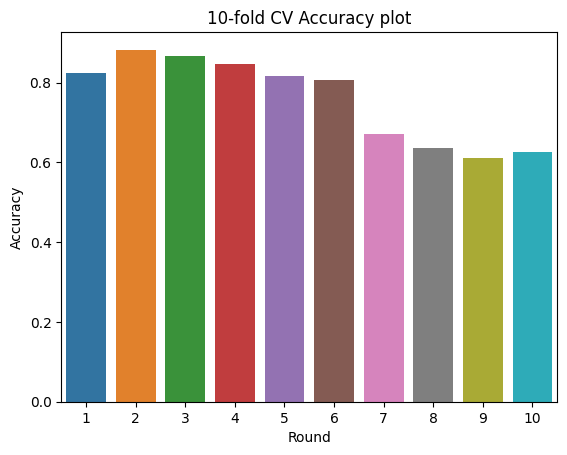

Score avg on 10-fold CV: 0.7586733882367553


Final Model

Accuracy:  0.7614736800583792 

Classification Report

              precision    recall  f1-score   support

     Andando       0.74      0.75      0.74     12446
     Autobus       0.63      0.63      0.63      7392
   Bicicleta       0.42      0.43      0.43      2422
       Coche       0.84      0.84      0.84     25373
        Tren       0.77      0.76      0.76      3070

    accuracy                           0.76     50703
   macro avg       0.68      0.68      0.68     50703
weighted avg       0.76      0.76      0.76     50703
 

Confusion Matrix



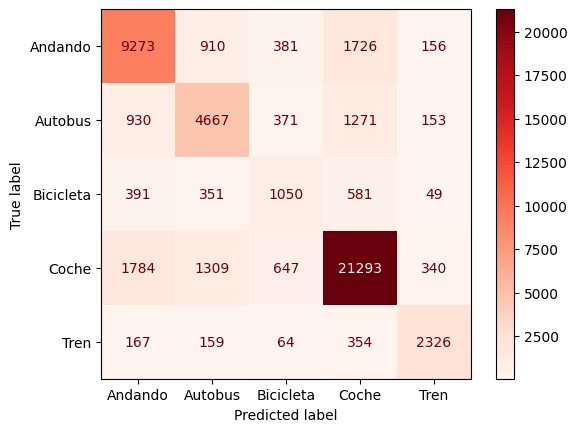

In [30]:
# rf = RandomForestClassifier(n_estimators=20,random_state=random_state)
# rf = DecisionTreeClassifier(max_depth=5)
# rf = AdaBoostClassifier()
# rf = KNeighborsClassifier()
rf = AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),learning_rate=0.5, n_estimators=20,random_state=random_state)
train_evaluate(rf)

In [87]:
# Display the first tree of the random forest

from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

one_tree = rf.estimators_[0]

plt.figure(figsize=(10, 8))
plot_tree(one_tree,filled=True, rounded=True)
plt.show()

KeyboardInterrupt: 

Elapsed time to compute the importances: 0.011 seconds


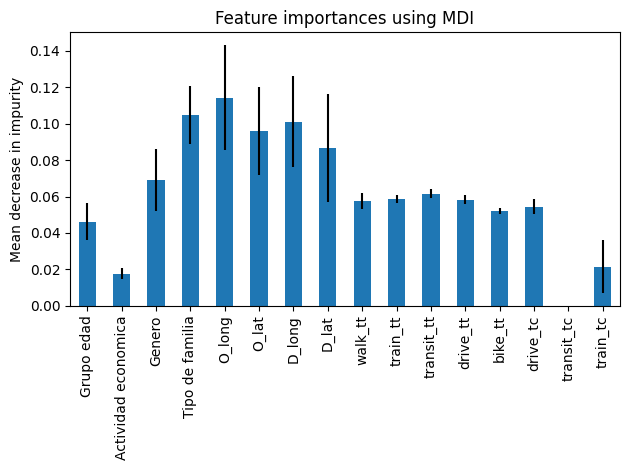

In [44]:
import time
import numpy as np

start_time = time.time()
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
import pandas as pd
forest_importances = pd.Series(importances, index=trips.drop(columns='MODO_INFORME').columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [30]:
# rf = RandomForestClassifier(n_estimators=20,random_state=random_state,class_weight='balanced')
# train_evaluate(rf)

# Backup

### ADA Boost - Decision Tree

In [31]:
# abc = AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),learning_rate=0.5, n_estimators=20,random_state=random_state)
# train_evaluate(abc)

### KNN

In [32]:
# knn = GridSearchCV(KNeighborsClassifier(),param_grid={'n_neighbors':list(range(10,21,5))},cv=10).fit(X,y)

In [33]:
# knn.best_params_

In [34]:
# knn = knn.best_estimator_
# train_evaluate(knn)

## SVM

In [35]:
# svm_linear = GridSearchCV(SVC(kernel='linear',random_state=seed),param_grid={'C':[1e-20,1e-10,0.00001,0.0001]},cv=10).fit(X,y)

In [36]:
# svm_linear.best_params_

In [37]:
# svm_linear = svm_linear.best_estimator_
# train_evaluate(svm_linear, cross_validation=False)

In [38]:
# pd.read_csv("data/San Antonio_no_NaNs.csv").primary_mode.value_counts()